In [94]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
import json
import pickle
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import matplotlib.patches as mpatches

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [95]:
df = df.loc[df.classifier == 'SVM']

In [96]:
df['type_of_transfer'] = df.type_of_transfer.map({
    'Same device type in same place': 'Replaced device',
    'Same device type in different place': 'Different placement',
    'Same device in different place': 'Different placement',
    'Same device type across spaces': 'Different room',
    'Same device across spaces': 'Different room',
    'Different device in same place': 'Different sensor board',
    'Same device in same place': '__remove__',
    'Different device in different place': '__remove__',
    'Different device across spaces': '__remove__',
    'No transfer': 'No transfer'
})

df = df.loc[df.type_of_transfer != '__remove__']

In [97]:
def to_key(row):
    return '_'.join(row[[
        'source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'
    ]])

df['key'] = [to_key(row) for i, row in df.iterrows()]

In [98]:
df_all = df
# df = df.loc[df.f1 >= 0.25]

In [99]:
df_all_features = df.loc[df.features_name == 'All']
df_not_all_features = df.loc[df.features_name != 'All']

def f1_all(key):
    rows = df_all_features.loc[df_all_features['key'] == key]
    if len(rows):
        return rows['f1'].iloc[0]
    return 0

# df_not_all_features = df_not_all_features.loc[df_not_all_features.f1 >= 0.25]
df_not_all_features['f1_all'] = [f1_all(row['key']) for i, row in df_not_all_features.iterrows()]

/home/giotto/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [100]:
df_not_all_features = df_not_all_features.loc[df_not_all_features.f1 - df_not_all_features.f1_all > 0.1]

In [101]:
df_not_all_features.features_name.value_counts()

Microphone                      1101
Microphone & accelerometer      1044
Accelerometer & magnetometer     638
Environmental                    429
EMI & motion                     161
Name: features_name, dtype: int64

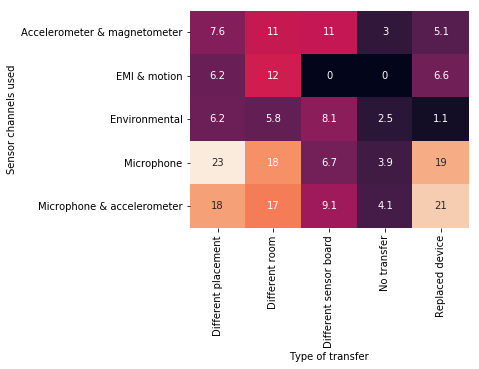

In [111]:
plt.rcParams["figure.figsize"] = (5, 4)

import seaborn

_df = df_not_all_features.groupby(['features_name', 'type_of_transfer']).size()
_df = _df / df.groupby(['features_name', 'type_of_transfer']).size()
_df = _df.reset_index()
_df = _df.pivot_table(index='features_name', columns='type_of_transfer', values=0)
_df = _df.loc[_df.index != 'All']
_df = _df.fillna(0)
_df *= 100
seaborn.heatmap(_df, annot=True, cbar=None)
plt.xlabel('Type of transfer')
plt.ylabel('Sensor channels used')